In [33]:
import os
import json
import numpy as np
from nuscenes.nuscenes import NuScenes

## TODOs

- filter and find scences with pedestrians
- render trajectories
- render prediction path

## Prediction annotation and results

python tools/prediction_eval.py --result_path 'work_dirs/vip3d_resnet50_3frame.1/results_nusc.json'

this command compares the results_nusc.json generated in eval session to the nuscenes_prediction_infos_val.json


nusc_eval = PredictionEval(result_path=args.result_path,
                               prediction_infos_path=args.prediction_infos_path)
                               
nusc_eval.main() -> self.evaluate()

In [5]:
fn_pred_infos = "./nuscenes_prediction_infos_val.json"
fn_result_nusc = "./work_dirs/vip3d_resnet50_3frame/results_nusc.json"
assert os.path.exists(fn_result_nusc), 'Error: The result file does not exist!'
assert os.path.exists(fn_pred_infos), 'Error'

In [10]:
class cfg:
    pred_traj_num = 6
    future_frame_num = 12
    max_dis_from_ego = 50.0
    matching_threshold = 2.0
    miss_rate_threshold = 2.0
    false_positive_penalty_coefficient = 0.5
    
class GTAgent:
    def __init__(self,
                 translation: np.ndarray = np.zeros(2),
                 future_traj: np.ndarray = np.zeros((cfg.future_frame_num, 2)),
                 future_traj_is_valid: np.ndarray = np.zeros(cfg.future_frame_num, dtype=np.int)
                 ):
        self.translation = translation.copy()
        self.future_traj = future_traj.copy()
        self.future_traj_is_valid = future_traj_is_valid.copy()


class PredAgent:
    def __init__(self,
                 sample_token: str = "",
                 translation: np.ndarray = np.zeros(2),
                 pred_future_trajs: np.ndarray = np.zeros((cfg.pred_traj_num, cfg.future_frame_num, 2)),
                 ):
        self.sample_token = sample_token
        self.translation = translation.copy()
        self.pred_future_trajs = pred_future_trajs.copy()

    @classmethod
    def deserialize(cls, content: dict):
        """ Initialize from serialized content. """
        
        if 'pred_outputs' in content:
            content['pred_future_trajs'] = content['pred_outputs']

        translation = np.array(content['translation'][:2])
        pred_future_trajs = np.array(content['pred_future_trajs'])

        return cls(
            translation=translation,
            pred_future_trajs=pred_future_trajs,
        )



In [24]:
with open(fn_result_nusc) as f:
    data = json.load(f)
    if 'results' in data:
        data = data['results']

    sample_token_2_pred_agents = {}
    for sample_token, boxes in data.items():
        sample_token_2_pred_agents[sample_token] = [PredAgent.deserialize(each) for each in boxes]

with open(fn_pred_infos, 'r') as f:
    prediction_infos = json.load(f)
    prediction_vals = [value for key, value in prediction_infos.items()]
    prediction_keys = [key for key, value in prediction_infos.items()]

In [12]:
len(data.items()), len(prediction_infos.items())

(6019, 6019)

In [26]:
prediction_keys[0], prediction_vals[0].keys()

('30e55a3ec6184d8cb1944b39ba19d622',
 dict_keys(['sample_token', 'timestamp', 'instance_inds', 'gt_bboxes_3d', 'gt_labels_3d']))

In [27]:
prediction_vals[0]["instance_inds"]

[17291, 17294, 17299, 17300, 17302, 17309, 17319, 17320]

In [28]:
prediction_vals[0]["gt_labels_3d"]

[0, 5, 5, 6, 6, 6, 6, 6]

class_names = [
    'car', 'truck', 'bus', 'trailer',
    'motorcycle', 'bicycle', 'pedestrian',
]

## Load Nuscenes

In [35]:
nusc = NuScenes(version="v1.0-trainval", dataroot="data/nuscenes", verbose=True)

Loading NuScenes tables for version v1.0-trainval...
Loading nuScenes-lidarseg...
32 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
34149 lidarseg,
Done loading in 16.751 seconds.
Reverse indexing ...
Done reverse indexing in 3.0 seconds.


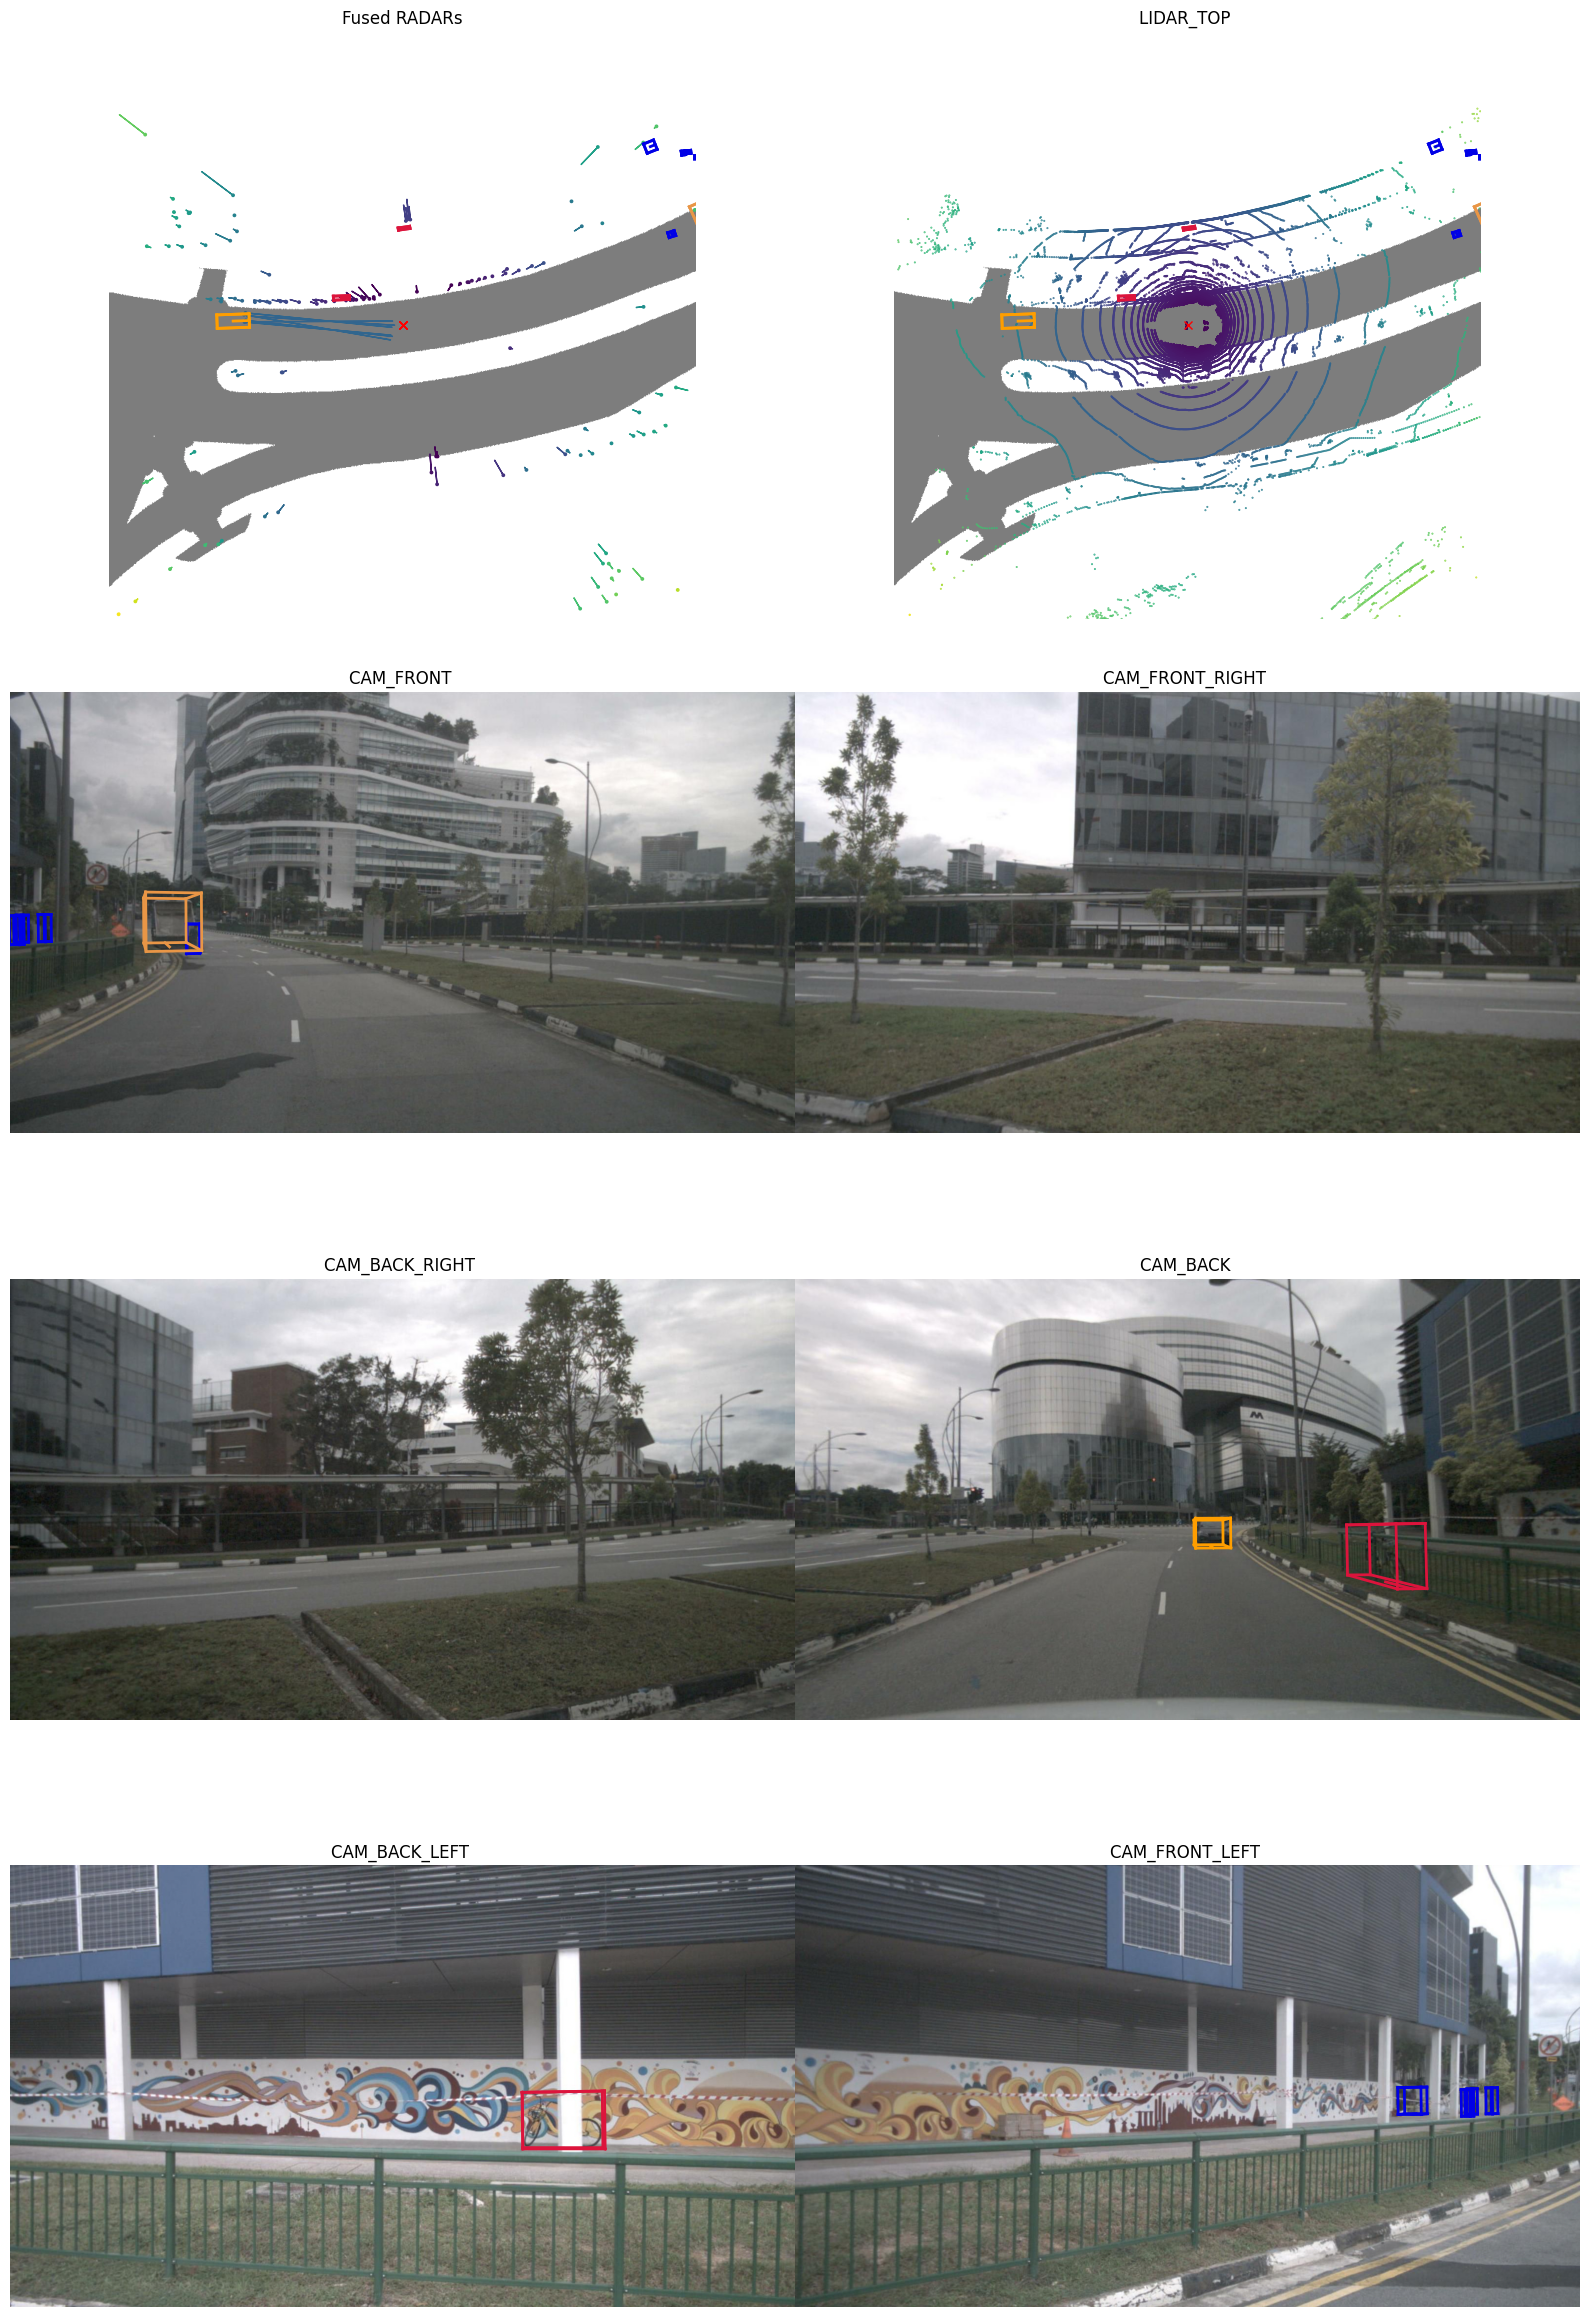

In [39]:
nusc.render_sample('30e55a3ec6184d8cb1944b39ba19d622')

In [41]:
nusc.get("sample", '30e55a3ec6184d8cb1944b39ba19d622')

{'token': '30e55a3ec6184d8cb1944b39ba19d622',
 'timestamp': 1531281439800013,
 'prev': '',
 'next': 'cc18fde20db74d30825b0b60ec511b7b',
 'scene_token': 'c3ab8ee2c1a54068a72d7eb4cf22e43d',
 'data': {'RADAR_FRONT': '3f538f1d994c4b91821a274995df6b54',
  'RADAR_FRONT_LEFT': 'e5301eb70d684749959224bc76a13967',
  'RADAR_FRONT_RIGHT': '5364ed5a2f2c4916863e15ff7a0a0336',
  'RADAR_BACK_LEFT': 'cbd59e48cb14442ca888e591a4495e74',
  'RADAR_BACK_RIGHT': 'c975a3a418074436b2f13ed0a7ef592a',
  'LIDAR_TOP': 'a9f20e17155844bbb5e3781a8a0e206c',
  'CAM_FRONT': '1c771ca93bd14e5cb652d0fe44c882ea',
  'CAM_FRONT_RIGHT': 'c9fb560989ba4f11b67a388b34f4addc',
  'CAM_BACK_RIGHT': 'ec49e2305a804d81bebcfd2f5873b347',
  'CAM_BACK': '530fabc254fd46c298e27a2177880a97',
  'CAM_BACK_LEFT': 'b4c1bb0ef14a4b808420801853a58a36',
  'CAM_FRONT_LEFT': '0ae4ce1d75c5425486d049cd5d785245'},
 'anns': ['497447b8eded460f923ea7430bc9a4fc',
  '28ff090f95aa4338886c40a06820dcca',
  '42fd6a5f10974c1a862bda9e73a268ff',
  'd83664808c6944959

In [43]:
nusc.get("scene", "c3ab8ee2c1a54068a72d7eb4cf22e43d") 

{'token': 'c3ab8ee2c1a54068a72d7eb4cf22e43d',
 'log_token': 'a5bb7f9dd1884f1ea0de299caefe7ef4',
 'nbr_samples': 39,
 'first_sample_token': '30e55a3ec6184d8cb1944b39ba19d622',
 'last_sample_token': 'e59fefa1fc19406782779392dff95366',
 'name': 'scene-0268',
 'description': 'Construction zone, stopped at red light, parked cars'}

In [59]:
nusc.get("category", "1fa93b757fc74fb197cdd60001ad8abf")

{'token': '1fa93b757fc74fb197cdd60001ad8abf',
 'name': 'human.pedestrian.adult',
 'description': 'Adult subcategory.',
 'index': 2}

In [58]:
nusc.category[2]

{'token': '1fa93b757fc74fb197cdd60001ad8abf',
 'name': 'human.pedestrian.adult',
 'description': 'Adult subcategory.',
 'index': 2}

## pkl files 

In [1]:
import pickle
with open("data/nuscenes/nuscenes_tracking_infos_val.pkl", "rb") as fn:
    val_pkl = pickle.load(fn)

In [12]:
val_pkl.keys(), val_pkl["metadata"]

(dict_keys(['infos', 'metadata']), {'version': 'v1.0-trainval'})

In [22]:
val_pkl["infos"][0].keys()

dict_keys(['lidar_path', 'token', 'sweeps', 'cams', 'radars', 'lidar2ego_translation', 'lidar2ego_rotation', 'ego2global_translation', 'ego2global_rotation', 'timestamp', 'gt_boxes', 'gt_names', 'gt_velocity', 'num_lidar_pts', 'num_radar_pts', 'valid_flag', 'instance_inds'])

In [23]:
val_pkl["infos"][0]["token"]

'fd8420396768425eabec9bdddf7e64b6'

In [25]:
val_pkl["infos"][0]["ego2global_translation"]

[249.89610931430778, 917.5522573162784, 0.0]

In [19]:
with open("data/nuscenes/nuscenes_infos_temporal_val.pkl", "rb") as fn:
    val_temp_pkl = pickle.load(fn)

In [20]:
val_temp_pkl["infos"][0].keys()

dict_keys(['lidar_path', 'token', 'prev', 'next', 'can_bus', 'frame_idx', 'sweeps', 'cams', 'scene_token', 'lidar2ego_translation', 'lidar2ego_rotation', 'ego2global_translation', 'ego2global_rotation', 'timestamp', 'gt_boxes', 'gt_names', 'gt_velocity', 'num_lidar_pts', 'num_radar_pts', 'valid_flag'])